# Objective: Detection of Covid19 using the CT-Scan images

this model is trained on the CT-SCAN images of patient to predict he/she is Covid patient or not.
the data is marked in two class COVID and Non-Covid.

## 1. Importing Libraries

In this section importing the important libraries. which is required to train the model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

*   os: Provides a way to interact with the operating system, such as checking file existence, creating directories, etc.
*   numpy: A library for numerical computations in Python.
*   matplotlib.pyplot: A plotting library used for data visualization.
*   tensorflow: A popular deep learning framework for building and training machine learning models.
*   math: Provides mathematical functions and operations.
*   shutil: Allows file and directory operations like moving, copying, and deleting.
*   ImageDataGenerator: A class for generating augmented images from the dataset.
*   ResNet50: A pre-trained deep learning model architecture for image classification.
*   Dense: A layer class that represents a fully connected layer in a neural network.
*   GlobalAveragePooling2D: A pooling layer that performs spatial average pooling.
*   Model: A class for defining and training neural network models.
*   EarlyStopping: A callback class that stops training if a certain criterion is not met.
*   ModelCheckpoint: A callback class that saves the best model during training.
*   accuracy_score: A function for computing the accuracy metric.
*   precision_score: A function for computing the precision metric.
*   recall_score: A function for computing the recall metric.
*   f1_score: A function for computing the F1-score metric.







## 2. Importing Dataset
in this section i have just seperate a data into a train test and val folder which where used later on to train the model

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/COVID19_project/Data'

In [ ]:
#checking shape of data
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir]= len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
def create_folder(pth,split):
    if not os.path.exists("./train_"):
        os.mkdir( "./"+pth)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./" + pth+"/"+dir)

            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                        size= (math.floor(split*number_of_images[dir])-5),
                                        replace= False):
                O = os.path.join(ROOT_DIR,dir,img) #path
                D = os.path.join("./"+pth, dir)
                shutil.copy(O,D)
    else:
        print(f"{pth}the folder is exist")

This function, create_folder(pth, split), creates a new folder and performs a split of the images from a given directory into multiple subdirectories based on the provided split ratio.

**pth:** The path or name of the folder to be created.

**split:** The split ratio indicating the percentage of images to be allocated for training.

In [ ]:
if not os.path.exists('/content/train'):
    create_folder("train",0.7)
    create_folder("val",0.15)
    create_folder("test",0.15)
else:
    print("File already exists.")

File already exists.


checking the data (images)

Found 2480 files belonging to 2 classes.


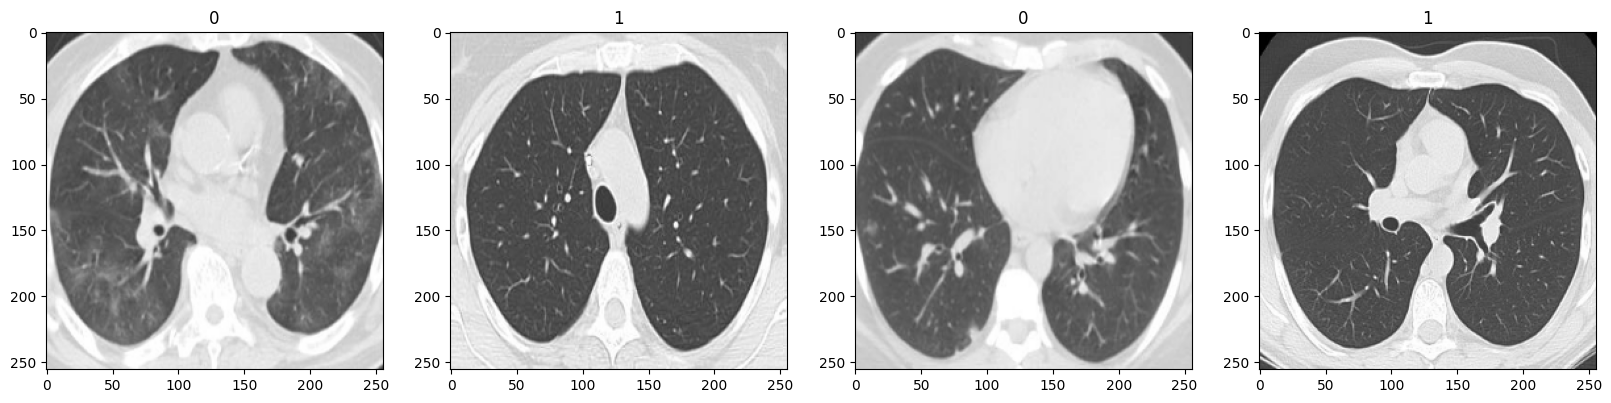

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(ROOT_DIR)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Set Size of an Image

just creating a variable which later on used for the sizing of the images

In [ ]:
target_size = (180, 180)

## 3. Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

By applying these data augmentation techniques, the ImageDataGenerator can generate augmented images on-the-fly during the training process. This helps increase the variability of the training data, which can improve the model's ability to generalize and handle different variations of the input data.

In [ ]:
def image_processing(image):

    # Read the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)

    # Smooth the image using Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding to enhance image contrast
    _, thresholded = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to remove noise and improve image structure
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)

    # Find contours of objects in the image
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

    return image_with_contours

## 4. Creating a ResNet50 Model

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

## 5. Perform Augmentation on data and create Train & Val variable

in this section the data we have splited in different folder we will store it in the varibale Train and Val using that folder path.
also applying the Augmentation on that Data

In [ ]:
# 5. Perform data augmentation
train_data_dir = '/content/train'
validation_data_dir = '/content/val'

In [ ]:
x_train = datagen.flow_from_directory(train_data_dir, target_size=target_size, batch_size=32)
x_val = datagen.flow_from_directory(validation_data_dir, target_size=target_size, batch_size=32)

Found 1725 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


## 6. Training Model

In [ ]:
model.fit(x_train, epochs=30, validation_data=x_val,callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
54/54 [==============================] - 74s 632ms/step - loss: 0.5705 - accuracy: 0.8023 - val_loss: 3.4998 - val_accuracy: 0.4972
Epoch 2/100
54/54 [==============================] - 36s 673ms/step - loss: 0.3423 - accuracy: 0.8620 - val_loss: 11.3313 - val_accuracy: 0.4972
Epoch 3/100
54/54 [==============================] - 43s 797ms/step - loss: 0.3367 - accuracy: 0.8655 - val_loss: 1.0070 - val_accuracy: 0.5028
Epoch 4/100
54/54 [==============================] - 31s 567ms/step - loss: 0.2957 - accuracy: 0.8783 - val_loss: 1.2859 - val_accuracy: 0.5028
Epoch 5/100
54/54 [==============================] - 31s 569ms/step - loss: 0.2693 - accuracy: 0.8875 - val_loss: 1.1316 - val_accuracy: 0.4972
Epoch 6/100
54/54 [==============================] - 34s 630ms/step - loss: 0.2603 - accuracy: 0.8974 - val_loss: 4.0854 - val_accuracy: 0.4972
Epoch 7/100
54/54 [==============================] - 32s 589ms/step - loss: 0.2525 - accuracy: 0.9014 - val_loss: 2.5222 - val_accuracy

In [ ]:
model.load_weights('best_model.h5')

Loading the trained weight so that we dont need to run this model from starting it save our time by saving their weights in seperatar folder

## 7. Perform prediction through the model

use test folder to take prediction from the model. the prediction is stored in the pred variable.

In [ ]:
test_data_dir = '/content/test'
test = datagen.flow_from_directory(test_data_dir, target_size=target_size, batch_size=32, shuffle=False)

Found 361 images belonging to 2 classes.


In [ ]:
predictions = model.predict(test)
predicted_labels = np.argmax(predictions, axis=1)

12/12 [==============================] - 8s 577ms/step


In [ ]:
# Get true labels
num_test_samples = test.samples
true_labels = test.classes[:num_test_samples]

## 8. Checking the performance of the model

In this section checking the model performance by different metrics such as accuracy, percision, recall and f1.

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# show performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.37950138504155123
Precision: 0.36207375512188344
Recall: 0.37807723003253735
F1-score: 0.360010130429277
